In [90]:
import os
import sys
import ccdproc
import ccdproc as ccdp
import matplotlib.pyplot as plt
import numpy as np


from astropy import units as u
from astropy.nddata import CCDData
from astropy.visualization import hist
from astropy.stats import mad_std
from ccdproc import ImageFileCollection
from aperturePhot import showimage as show_image 
from pathlib import Path



In [91]:
sys.path.append('/home/idies/workspace/Storage/svhuezo21/persistent/hrpo-pipeline/20210908')

data_dir_base = '/home/idies/workspace'
data_dir = 'Storage/svhuezo21/persistent/hrpo-pipeline/20210908'
data_dir = os.path.join(data_dir_base, data_dir)

#Make a directory to store reduced images
reduced_data = Path(data_dir, 'reduced_images')
reduced_data.mkdir(exist_ok=True)

In [92]:
#Load all of the datafiles
files = ccdp.ImageFileCollection(data_dir)

In [93]:
#Print out summary of data file with selected headers 
files.summary['file', 'imagetyp', 'filter', 'exptime', 'naxis1', 'naxis2']

file,imagetyp,filter,exptime,naxis1,naxis2
str20,str11,object,float64,int64,int64
Bias-001.fit,Bias Frame,--,0.0,1024,1024
Bias-002.fit,Bias Frame,--,0.0,1024,1024
Bias-003.fit,Bias Frame,--,0.0,1024,1024
Bias-004.fit,Bias Frame,--,0.0,1024,1024
Bias-005.fit,Bias Frame,--,0.0,1024,1024
Bias-006.fit,Bias Frame,--,0.0,1024,1024
Bias-007.fit,Bias Frame,--,0.0,1024,1024
Bias-008.fit,Bias Frame,--,0.0,1024,1024
Bias-009.fit,Bias Frame,--,0.0,1024,1024


In [94]:
#Select the calibrated bias images and combine them
calibrated_biases = files.files_filtered(imagetyp='Bias Frame', include_path=True)

combined_bias = ccdp.combine(calibrated_biases,
                             method='median',
                             sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                             sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std, unit='adu')

combined_bias.meta['combined'] = True

combined_bias.write(os.path.join(reduced_data / 'combined_bias.fit'), overwrite=True)

In [95]:
#Select the calibrated dark images and combine them
calibrated_darks = files.files_filtered(imagetyp='Dark Frame', include_path=True)
reduced_darks =[]
exptime = []

for frame in calibrated_darks:
    image = ccdp.CCDData.read(frame, unit ='adu')
    exptime.append(image.header["exposure"])
    #Subtract bias from dark image and apend to reduced_darks list
    reduced_darks.append(ccdp.subtract_bias(image,combined_bias))

combined_darks = ccdp.combine(reduced_darks,
                             method='median',
                             sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                             sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std, unit='adu', scale = 1 / np.array(exptime) 
                             )

#Scale exposure and exptime to 1
combined_darks.header["exposure"] = 1
combined_darks.header["exptime"] = 1

print(combined_darks.header)

combined_darks.meta['combined'] = True

combined_darks.write(os.path.join(reduced_data / 'combined_darks.fit'), overwrite=True)
    
  

SIMPLE  =                    T                                                  BITPIX  =                   16 /8 unsigned int, 16 & 32 int, -32 & -64 real     NAXIS   =                    2 /number of axes                                  NAXIS1  =                 1024 /fastest changing axis                           NAXIS2  =                 1024 /next to fastest changing axis                   BSCALE  =   1.0000000000000000 /physical = BZERO + BSCALE*array_value           BZERO   =   32768.000000000000 /physical = BZERO + BSCALE*array_value           DATE-OBS= '2021-09-09T03:43:37' /YYYY-MM-DDThh:mm:ss observation start, UT      EXPTIME =                    1 / Exposure time in seconds                       EXPOSURE=                    1 / Exposure time in seconds                       SET-TEMP=  -20.000000000000000 /CCD temperature setpoint in C                   CCD-TEMP=  -19.887342750000002 /CCD temperature at start of exposure in C       XPIXSZ  =   13.000000000000000 /Pixel Wi

In [96]:
flat_imagetyp = 'Flat Field'
flat_filters = set(h['filter'] for h in files.headers(imagetyp=flat_imagetyp))
print(flat_filters)

{'Bessel B', 'Bessel R', 'Bessel V'}


In [100]:
#This inverse median function takes all the combined_flats and normalizes them to 1
scale = lambda a: 1/np.median(a)
#Create dictionary to store master_flats
master_flats = {}

#Select the calibrated flat with each filter and combine them

for filt in flat_filters:
    reduced_flats = []
    calibrated_flats = files.files_filtered(imagetyp = flat_imagetyp, filter = filt, include_path=True)
    
    #Select each flat and subtract bias, then subtract darks, then store new image to reduced_flats list   
    for flat in calibrated_flats:
        image = ccdp.CCDData.read(flat, unit = 'adu')
        image = ccdp.subtract_bias(image, combined_bias)
        image = ccdp.subtract_dark(image,combined_darks, scale = True, exposure_unit = u.s, exposure_time = "exptime")
        reduced_flats.append(image)
        
    combined_flats = ccdp.combine(reduced_flats,
                             method='median',
                             sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                             sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std, unit='adu', scale = scale 
                             )
   #Make a key for filt in master_flats dictionary and set equal to combined_flats
    master_flats[filt] = combined_flats.copy()
    
    combined_flats.write(reduced_data / (filt.replace(" ","_") + "_combined_flats.fit"), overwrite=True)
    
    

824.5081267356873 1.4826
819.0 832.9126968132039


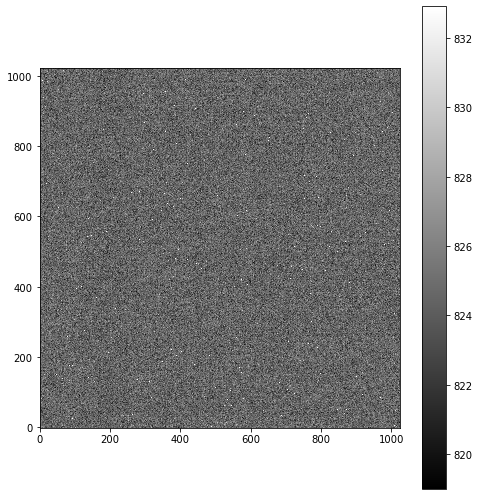

In [104]:
show_image(combined_bias)

0.1698211431503297 0.07412999999999997
-0.1 0.5474334184719558


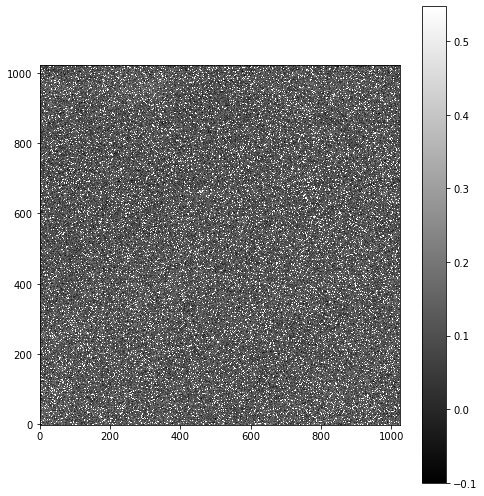

In [105]:
show_image(combined_darks)

1.0022177983222686 0.013305620889512149
0.9543039331548073 1.0780411840974198


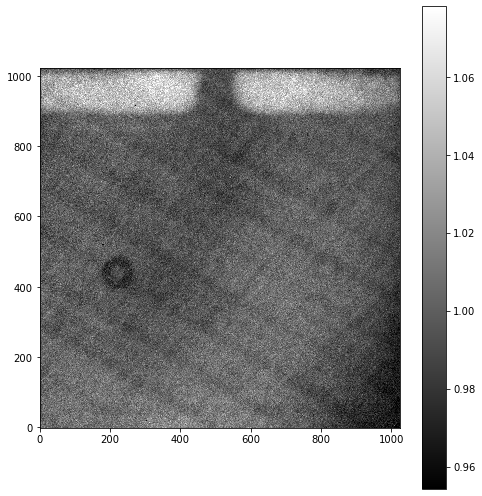

1.0025125684374492 0.009245869864865598
0.9705047380503715 1.0458096140149544


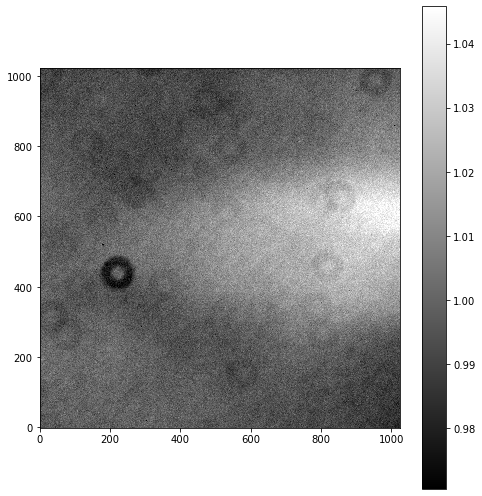

0.9999721430415163 0.006966719421259962
0.9772281639730311 1.0233389954063252


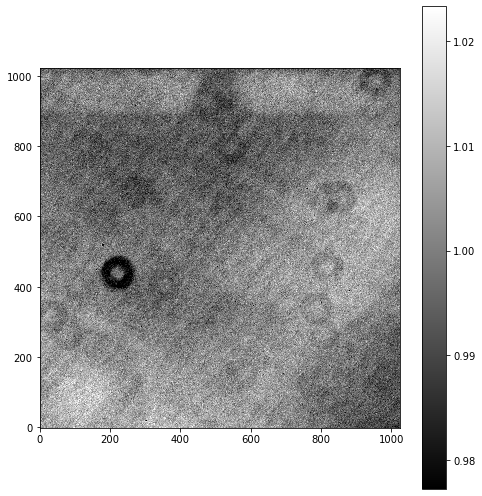

In [107]:
for filt,image in master_flats.items():
    show_image(image)

In [112]:

images = files.files_filtered(imagetyp='Light Frame', include_path=True)
for image in images:
    dim = ccdp.CCDData.read(image, unit = 'adu')
    var_filt = dim.header["filter"]
    
    #Accesses the correct flat by finding the correct filter in the master_flats dictionary
    corr_filt = master_flats[var_filt]
    #This next step is a single basic processing command to process all the image data
    dim = ccdproc.ccd_process(dim,
                           master_bias = combined_bias, dark_frame = combined_darks, master_flat = corr_filt,
                           exposure_key='exposure',
                           exposure_unit=u.second,
                           dark_scale=True,
                          )
    
    proc_data = os.path.basename(image)
    dim.write(reduced_data / ("BDF_" + proc_data), overwrite=True)
    

In [116]:
data = "Storage/svhuezo21/persistent/hrpo-pipeline/20210908/reduced_images/BDF_TabbysStar_001B.fit"
f = os.path.join(data_dir_base, data)

315.3846591901143 63.76359672013128
153.63248573066565 654.6918391191394


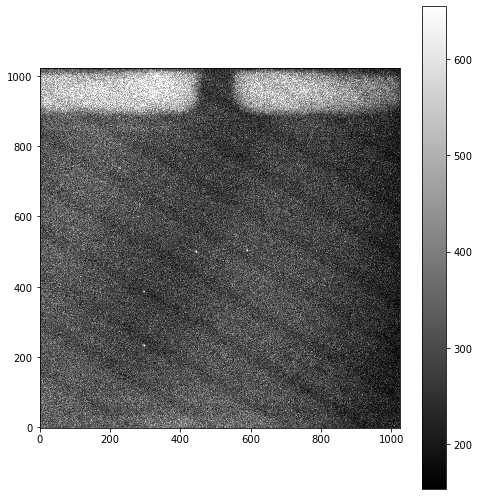

In [117]:
image = ccdp.CCDData.read(f)
show_image(image)